Liquidity (depth, spread, volatility) vs quote currency - Steven
- 1m return volatility.
- Depth proxies (volume / RV, inverse Amihud).
- Spread proxies (Roll covariance or, if you later get quotes, quoted/effective spreads). Roll model for spreads
- Compare BTC/USD vs BTC/USDT vs BTC/USDC and highlight systematic differences.
 

**Goals:**
- realized vol
- effective spread
- realized spread
- price impact
- trade-level
- Kyle's lambda
- order flow imbalance

In [1]:
# all imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm

sns.set_theme(style="darkgrid")
pd.set_option("display.precision", 4)
REGIME_ORDER = ["calm", "stress", "post"]

## Load Data
**Regimes (UTC, by date):**
- calm: date ≤ 2023-03-09
- stress: 2023-03-10 to 2023-03-14
- post: date ≥ 2023-03-15

In [2]:
bnus_spot_btc_usd = '../Data/ohlcv_1s_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
bnus_spot_btc_usdc = '../Data/ohlcv_1s_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
bnus_spot_btc_usdt = '../Data/ohlcv_1s_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

cbse_spot_btc_usd = '../Data/ohlcv_1s_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
cbse_spot_btc_usdt = '../Data/ohlcv_1s_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

trades_bnus_btc_usd = '../Data/trades_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
trades_bnus_btc_usdc = '../Data/trades_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
trades_bnus_btc_usdt = '../Data/trades_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

trades_cbse_btc_usd = '../Data/trades_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
trades_cbse_btc_usdt = '../Data/trades_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

trade_files = [
    {'exchange':'binance', 'pair':'BTC/USD', 'ohlc_path': bnus_spot_btc_usd, 'trade_path': trades_bnus_btc_usd},
    {'exchange':'binance', 'pair':'BTC/USDC', 'ohlc_path': bnus_spot_btc_usdc, 'trade_path': trades_bnus_btc_usdc},
    {'exchange':'binance', 'pair':'BTC/USDT', 'ohlc_path': bnus_spot_btc_usdt, 'trade_path': trades_bnus_btc_usdt},
    
    {'exchange':'coinbase', 'pair':'BTC/USD', 'ohlc_path': cbse_spot_btc_usd, 'trade_path': trades_cbse_btc_usd},
    {'exchange':'coinbase', 'pair':'BTC/USDT', 'ohlc_path': cbse_spot_btc_usdt, 'trade_path': trades_cbse_btc_usdt},
]

## Format 1 Minute Framework

I chose to analyze via a 1 minute because there are many missing 1s timestamps and I dont want to spend too long cleaning gaps etc. This way micro noise's effect is reduced. 1s intervals are not needed in regime comparison as well.

### Depth Proxies: *How much trading can happen without moving the price much?*
- [**Amihud Illiquidity**](https://ba-odegaard.no/teach/notes/liquidity_estimators/amihud_estimator/amihud_lectures.pdf): trade/return-based proxy for price impact
    - *How much does price move per dollar traded?*
    - higher value => worse liquidty

- [**Kyle's Lambda**](https://haas.berkeley.edu/wp-content/uploads/StocLiq21.pdf): estimates the slope of price response to a signed order flow
    - *How much does price move for a given net aggressive buy/sell flow?*
    - higher value => lower liquidity (given trade volume causes a larger price impact)
    
### Spread Proxies: *How high are the transaction costs?*
- **Roll Spread**: estimates the effective spread from bid-ask bounce
    - higher value => wider spreads => worse execution costs
    
https://pressacademia.org/archives/jefa/v3/i3/7.pdf

In [3]:
# adds regime labels
def add_regime_labels(in_df):
    out_df = in_df.copy()
    d = out_df.index.normalize()

    out_df['regime'] = np.select(
        [d <= pd.Timestamp('2023-03-09', tz='UTC'), d <= pd.Timestamp('2023-03-14', tz='UTC')], 
        ['calm', 'stress'],
        default='post'
    )
    return out_df


# ensure proper ts index for ohlc df
def load_ohlc(path):
    ohlc = pd.read_csv(path)
    ohlc['ts'] = pd.to_datetime(ohlc['timestamp'], unit='ms', utc=True)
    ohlc = ohlc.sort_values('ts').set_index('ts')

    for c in ['open','high','low','close','volume']:
        ohlc[c] = pd.to_numeric(ohlc[c], errors='coerce')

    ohlc = ohlc.dropna(subset=['close'])
    ohlc = ohlc[ohlc['volume'] > 0]
    ohlc = add_regime_labels(ohlc)
    
    return ohlc


# ensure proper ts index for trades df
def load_trades_ohlc(trades_path, ohlc_path):
    ohlc = load_ohlc(ohlc_path)
    
    # mid price proxy
    ohlc['mid'] = (ohlc['high'] + ohlc['low']) / 2.0
    
    trades = pd.read_csv(trades_path)
    trades['ts'] = pd.to_datetime(trades['timestamp'], unit='ms', utc=True)
    trades = trades.sort_values('ts').set_index('ts')
    
    trades = add_regime_labels(trades)
    
    trades = pd.merge_asof(
        trades,
        ohlc[['mid']],
        left_index=True,
        right_index=True,
        direction='backward'
    )
    
    # Merge 1-minute future mid price for Realized Spread
    trades['future_ts'] = trades.index + pd.Timedelta(minutes=1)
    trades = trades.reset_index()
    trades = pd.merge_asof(
        trades,
        ohlc[['mid']].rename(columns={'mid': 'future_mid'}),
        left_on='future_ts',
        right_index=True,
        direction='forward'
    )
    trades = trades.set_index('ts')
    
    return trades, ohlc

# resample ohlc bars
def resample_ohlc(ohlc_df, bar='1min'):
    g = ohlc_df.resample(bar)
    
    out = pd.DataFrame({
        'open': g['open'].first(),
        'high': g['high'].max(),
        'low':  g['low'].min(),
        'close':g['close'].last(),
        'volume': g['volume'].sum(),
    }).dropna(subset=['close','high','low'])
    
    out = out[out['volume'] > 0]
    out = add_regime_labels(out)
    
    return out


# format trades to 1m 
def resample_trades(trades_df, freq='1min'):
    df = trades_df.copy()

    df['dollar'] = df['price'] * df['amount']
    df['sign'] = np.where(df['taker_side_sell'].astype(bool), -1.0, +1.0)
    df['signed_dollar'] = df['sign'] * df['dollar']

    # vwap
    vwap_1m = df['dollar'].resample('1min').sum() / df['amount'].resample('1min').sum()

    out = pd.DataFrame({
        'vwap': vwap_1m,
        'last': df['price'].resample('1min').last(),
        'vol_dollar': df['dollar'].resample('1min').sum(),
        'n_trades': df['price'].resample('1min').count(),
        'signed_dollar': df['signed_dollar'].resample('1min').sum(),
    })

    out['ret'] = np.log(out['vwap']).diff()
    out['rv_1m'] = out['ret']**2
    out['amihud_1m'] = out['ret'].abs() / out['vol_dollar'].replace(0, np.nan)
    
    out = add_regime_labels(out)
    out = out.dropna(subset=['vwap', 'ret', 'vol_dollar'])
    
    return out 


def ohlc_from_trades(trades, bar="1min"):
    g = trades.resample(bar)
    out = pd.DataFrame({
        "open":  g["price"].first(),
        "high":  g["price"].max(),
        "low":   g["price"].min(),
        "close": g["price"].last(),
        "volume": g["amount"].sum(),
        "n_trades": g["price"].count(),
    })
    out = out.dropna(subset=["open", "high", "low", "close"])
    out = out[out["n_trades"] > 0]
    return add_regime_labels(out)

In [4]:
# calc kyle lambda
def kyle_lambda_by_regime(trades_1m):
    df = trades_1m.copy()

    def fit_lambda(df):
        df = df[['ret', 'signed_dollar']].dropna()
        y = df['ret'].to_numpy()
        x = df['signed_dollar'].to_numpy()
        
        X = np.column_stack([np.ones_like(x), x])
        a, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        
        return float(a[1]) * 1000000.0

    kyle = df.groupby('regime', sort=False).apply(fit_lambda)
    kyle.name = 'lambda'
    
    return kyle

In [5]:
def roll_from_trades(trades_df):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    r = np.log(P).diff().dropna()
    roll_cov = np.cov(r[1:], r[:-1])[0,1]
    
    if pd.isna(roll_cov) or roll_cov >= 0: return np.nan
    
    roll_spread = 2 * np.sqrt(-roll_cov)
    roll_spread_bps = roll_spread * 10_000

    return roll_spread_bps

def roll_by_regime_from_trades(trades_df):       
    rs = trades_df.groupby("regime", sort=False).apply(lambda g: roll_from_trades(g))
    rs.name = "roll_spread"
    
    return rs.reindex(REGIME_ORDER)

In [6]:
def es_from_trades(trades_df, agg='median'):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    mid = g['mid'].astype(float)
    
    exp_spread = 2 * side * (P - mid)
    exp_spread_bps = (exp_spread / P) * 10000
    
    exp_spread_bps = exp_spread_bps.replace([np.inf, -np.inf], np.nan).dropna()
    exp_spread_bps = exp_spread_bps[(exp_spread_bps > -500) & (exp_spread_bps < 500)]
    
    if agg == 'mean':
        return exp_spread_bps.mean()
    else: 
        return exp_spread_bps.median()
    
def es_by_regime_from_trades(trades_df,  agg='mean'):
    es = trades_df.groupby("regime", sort=False).apply(lambda g: es_from_trades(g, agg=agg))
    es.name = "expected_spread"

    return es.reindex(REGIME_ORDER)

In [7]:
def rs_from_trades(trades_df, agg='median'):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    
    future_mid = g['future_mid'].astype(float)
    
    realized_spread = 2 * side * (P - future_mid)
    realized_spread_bps = (realized_spread / P) * 10000
    
    realized_spread_bps = realized_spread_bps.replace([np.inf, -np.inf], np.nan).dropna()
    realized_spread_bps = realized_spread_bps[(realized_spread_bps > -500) & (realized_spread_bps < 500)]
    
    if agg == 'mean':
        return realized_spread_bps.mean()
    else: 
        return realized_spread_bps.median()   

def rs_by_regime_from_trades(trades_df, agg='mean'):
    rs = trades_df.groupby("regime", sort=False).apply(lambda g: rs_from_trades(g, agg=agg))
    rs.name = "realized_spread"

    return rs.reindex(REGIME_ORDER)

In [18]:
# generate analysis summary value table
def summarize_liquidity(trades_df, roll_series, kyle_series, es_series, rs_series):
    
    def summ(g):
        nobs = len(g)
        n_trades = g['n_trades'].sum()
        vol_dollar = g['vol_dollar'].sum()
        rv_sum = g['rv_1m'].sum()
        rv_mean = g['rv_1m'].mean()
        sigma_ann = np.sqrt(rv_mean) * np.sqrt(525600)

        amihud_mean = g['amihud_1m'].mean()
        amihud_median = g['amihud_1m'].median()

        return pd.Series({
            'nobs': nobs,
            'n_trades': n_trades,
            'vol_dollar': vol_dollar,
            'rv_sum': rv_sum,
            'rv_mean': rv_mean,
            'sigma_ann': sigma_ann,
            'amihud_mean': amihud_mean,
            'amihud_median': amihud_median,
            'depth_proxy_vol_over_rv': vol_dollar / rv_mean if rv_mean > 0 else np.nan,
            'inv_amihud_median': 1.0 / amihud_median if amihud_median > 0 else np.nan,
            'n_trades_per_min': n_trades / nobs if nobs > 0 else np.nan,
            'avg_trade_dollar': vol_dollar / n_trades if n_trades > 0 else np.nan,
        })
    
    summ_df = trades_df.groupby('regime', observed=True).apply(summ).reindex(REGIME_ORDER)
    
    if roll_series is not None:
        summ_df['roll_spread'] = roll_series.reindex(REGIME_ORDER).to_numpy()
    if kyle_series is not None:
        summ_df['kyle_lambda_scaled'] = np.abs(kyle_series.reindex(REGIME_ORDER).to_numpy())
    if es_series is not None:
        summ_df['es_spread'] = es_series.reindex(REGIME_ORDER).to_numpy()
    if rs_series is not None:
        summ_df['rs_spread'] = rs_series.reindex(REGIME_ORDER).to_numpy()
    
    return summ_df

# runs across all exchanges and types
def run_liquidity_block(trade_files, agg):
    rows = []
    for spec in trade_files:
        trades, ohlc = load_trades_ohlc(spec['trade_path'], spec['ohlc_path'])
        panel = resample_trades(trades)
        
        roll = roll_by_regime_from_trades(trades)
        kyle = kyle_lambda_by_regime(panel)
        es = es_by_regime_from_trades(trades, agg=agg)
        rs = rs_by_regime_from_trades(trades, agg=agg)

        summ = summarize_liquidity(panel, roll, kyle, es, rs)
        summ = summ.reset_index().rename(columns={'index': 'regime'})
        summ['exchange'] = spec['exchange']
        summ['pair'] = spec['pair']
        rows.append(summ)

    out = pd.concat(rows, ignore_index=True)
    out['regime'] = pd.Categorical(out['regime'], categories=REGIME_ORDER, ordered=True)
    out = out.sort_values(['exchange', 'pair', 'regime']).reset_index(drop=True)
    
    return out

# plot table for given metric
def plot_metric(all_summary, metric, title, log=False):
    piv = all_summary.pivot_table(index=['exchange', 'pair'], columns='regime', values=metric, aggfunc='mean')
    piv = piv.reindex(columns=REGIME_ORDER)
    ax = piv.plot(kind='bar', figsize=(10, 4))
    ax.set_title(title)
    ax.set_ylabel(metric)
    if log: ax.set_yscale('log')
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend(title='regime')

    plt.tight_layout()
    plt.show()

In [11]:
all_summary = run_liquidity_block(trade_files, agg='mean')
all_summary

,regime,nobs,n_trades,vol_dollar,rv_sum,rv_mean,sigma_ann,amihud_mean,amihud_median,depth_proxy_vol_over_rv,inv_amihud_median,n_trades_per_min,avg_trade_dollar,roll_spread,kyle_lambda_scaled,es_spread,rs_spread,exchange,pair
0,calm,12818.0,1010373.0,1.1282e+09,0.0033,2.5387e-07,0.3653,3.5856e-08,4.7147e-09,4.4438e+15,2.1210e+08,78.8245,1116.5874,0.9781,0.0027,-0.4636,-0.0008,binance,BTC/USD
1,stress,7198.0,1601108.0,1.3028e+09,0.0072,1.0030e-06,0.7261,1.2216e-08,4.1701e-09,1.2989e+15,2.3980e+08,222.4379,813.7027,1.8801,0.0034,-0.9191,0.0492,binance,BTC/USD
2,post,10080.0,2823201.0,2.2948e+09,0.0073,7.2242e-07,0.6162,5.8539e-09,2.9690e-09,3.1765e+15,3.3681e+08,280.0795,812.8217,0.9257,0.0027,-0.5778,-0.0894,binance,BTC/USD
3,calm,4614.0,39506.0,2.9594e+07,0.0029,6.2668e-07,0.5739,1.1024e-06,1.1812e-07,4.7223e+13,8.4656e+06,8.5622,749.1046,0.8691,0.0278,-0.2739,1.3643,binance,BTC/USDC
4,stress,3660.0,61338.0,2.4318e+07,0.0281,7.6747e-06,2.0084,7.4358e-06,2.6044e-07,3.1686e+12,3.8396e+06,16.7590,396.4553,17.2087,0.0591,-1.8006,-6.1392,binance,BTC/USDC
5,post,4332.0,33371.0,2.1680e+07,0.0058,1.3275e-06,0.8353,8.9795e-06,3.0270e-07,1.6331e+13,3.3036e+06,7.7034,649.6547,1.0464,0.0499,-0.1827,0.9692,binance,BTC/USDC
6,calm,12069.0,418606.0,4.3146e+08,0.0033,2.7424e-07,0.3797,1.4314e-07,1.3253e-08,1.5733e+15,7.5456e+07,34.6844,1030.7044,1.1412,0.0066,-0.2345,0.7373,binance,BTC/USDT
7,stress,7053.0,413888.0,5.8810e+08,0.0072,1.0268e-06,0.7346,1.8860e-07,9.2672e-09,5.7274e+14,1.0791e+08,58.6825,1420.9089,1.7904,0.0054,-0.6788,0.4012,binance,BTC/USDT
8,post,9889.0,295484.0,4.2557e+08,0.0079,7.9995e-07,0.6484,6.6581e-07,2.0765e-08,5.3200e+14,4.8159e+07,29.8801,1440.2582,1.6640,0.0087,-0.6171,-0.1228,binance,BTC/USDT
9,calm,12674.0,2636263.0,2.3746e+09,0.0033,2.6266e-07,0.3716,6.1543e-09,1.8785e-09,9.0405e+15,5.3235e+08,208.0056,900.7499,0.4200,0.0012,0.1601,-0.4524,coinbase,BTC/USD


## Volatility Dynamics During Market Stress

- The empirical data reveals a crystal-clear signature of the March 2023 USDC depeg, most notably in the volatility profiles of stablecoin versus fiat quote currencies. Looking at the Annualized Return Volatility chart, Binance BTC/USDC experienced extreme instability where volatility jumped from 57% in the calm regime to a massive 200% during the stress regime, before settling back to 83% post-crisis.

- This volatility was accompanied by a severe panic-induced "flight to volume." As seen in the Trade Intensity chart, despite the stress period lasting only four days, BTC/USDC recorded 61,338 trades—vastly outpacing the 39,506 trades seen in the entire prolonged calm period preceding it. Without the robust framework of the GENIUS Act, legacy stablecoins were highly susceptible to traditional banking panics, transmitting off-chain banking risk directly into severe microstructure volatility in cross-currency crypto pairs.

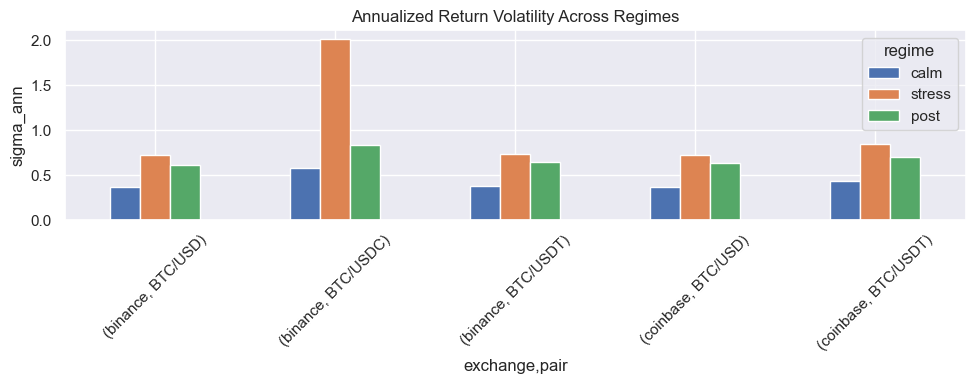

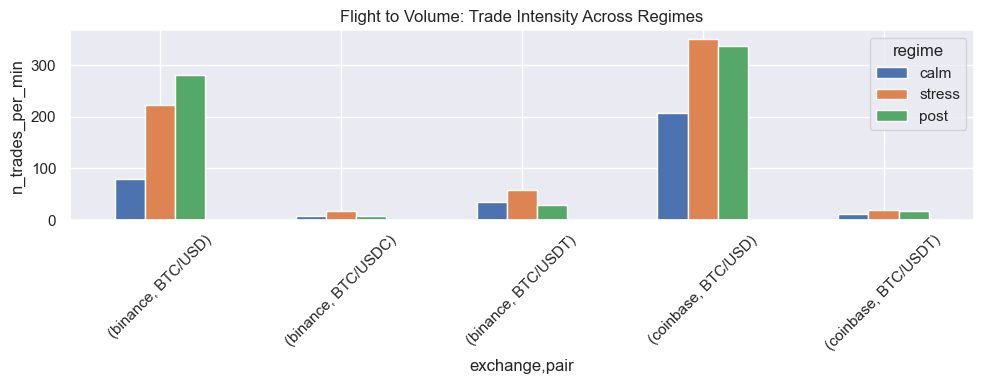

In [26]:
plot_metric(all_summary, 'sigma_ann', 'Annualized Return Volatility Across Regimes')
plot_metric(all_summary, 'n_trades_per_min', 'Flight to Volume: Trade Intensity Across Regimes')

## Market Depth and Resilience

- When analyzing order book absorption and price impact, pure fiat pairs were better in liquidity depth compared to their stablecoin counterparts. The Median Inverse Amihud Illiquidity chart illustrates that Fiat USD acts as an uncontested liquidity anchor. Coinbase BTC/USD’s inverse Amihud depth completely dwarfs all other pairs by orders of magnitude (note the logarithmic scale).

- The fiat pairs demonstrated remarkable resilience. During the height of the banking stress, the Amihud median for Coinbase BTC/USD actually remained stable and even slightly improved (from 1.87×10−9 to 1.52×10−9). The higher inverse values imply deeper market depth, meaning the fiat order book effortlessly absorbed the massive volume surge with minimal price impact for traders. In contrast, unregulated stablecoin pairs lacked this structural resilience when the peg came under pressure.

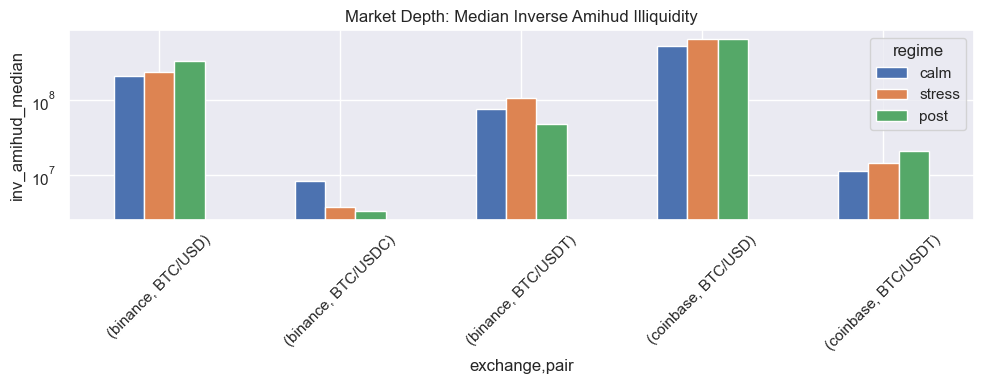

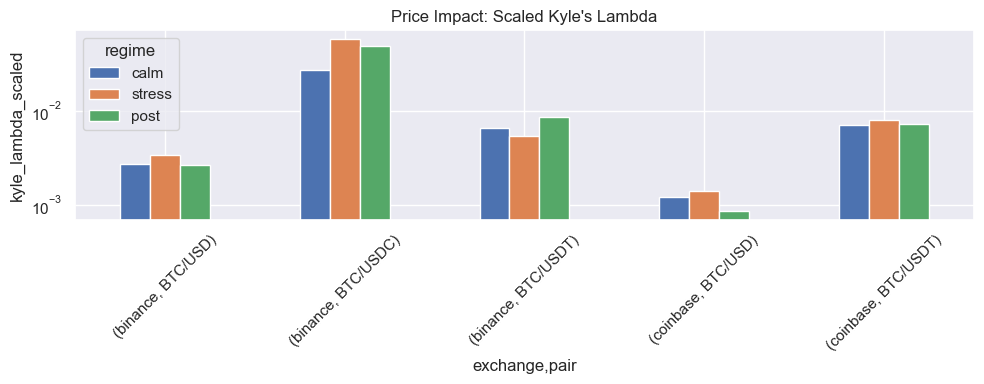

In [30]:
plot_metric(all_summary, 'inv_amihud_median', 'Market Depth: Median Inverse Amihud Illiquidity', True) # higher
plot_metric(all_summary, 'kyle_lambda_scaled', 'Price Impact: Scaled Kyle\'s Lambda', True) # lower

## Spread Proxies
- Bid-ask spread proxies further illustrate the fragmentation of liquidity across quote currencies. The Roll Implied Spreads chart starkly captures the evaporation of liquidity in the stablecoin market during the crisis. For Binance BTC/USDC, the roll spread spiked from a baseline of 0.86 bps to an astonishing 17.2 bps during the stress regime.

- Conversely, Coinbase BTC/USD maintained the tightest spread by far. In the calm period, it averaged just 0.42 bps, compared to Binance BTC/USDT (1.14 bps) and Binance BTC/USDC (0.86 bps). Even during the peak of the stress period, Coinbase's BTC/USD spread widened to a mere 1.11 bps, effectively resisting the contagion that drove USDC spreads up by 20x.

- The Effective Spread show values hovering around -0.5 to +0.5 bps. These metrics were estimated using 1-second OHLC mid-prices due to the absence of Level 2 quote (order book) data, which introduces intra-second microstructure latency artifacts. Because we are using 1-second OHLC data to proxy the mid-price, high-frequency trades often appear to execute "inside" or "past" the stale 1-second mid-price, resulting in slightly negative effective spreads. Interestingly, Coinbase leans slightly positive while Binance leans slightly negative, likely due to micro-differences in how their respective matching engines report trade timestamps. Because of these L2 data limitations, this study relies on the Roll Spread, Kyle's Lambda, and Amihud Illiquidity, all of which are calculated from executed trades as the most robust measures of market friction.

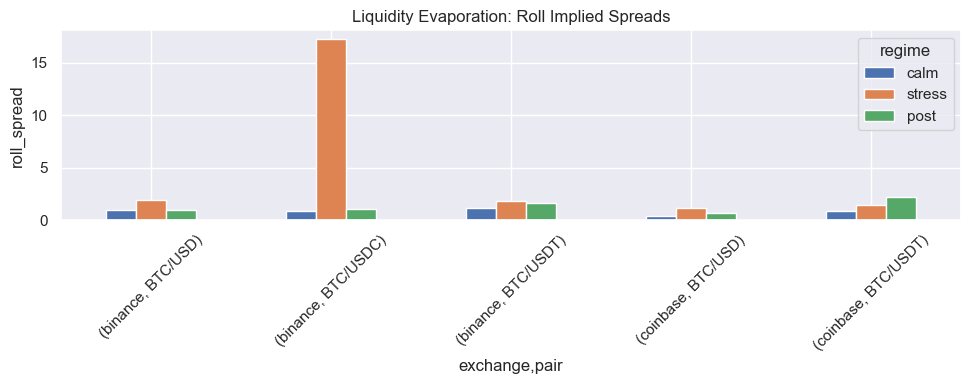

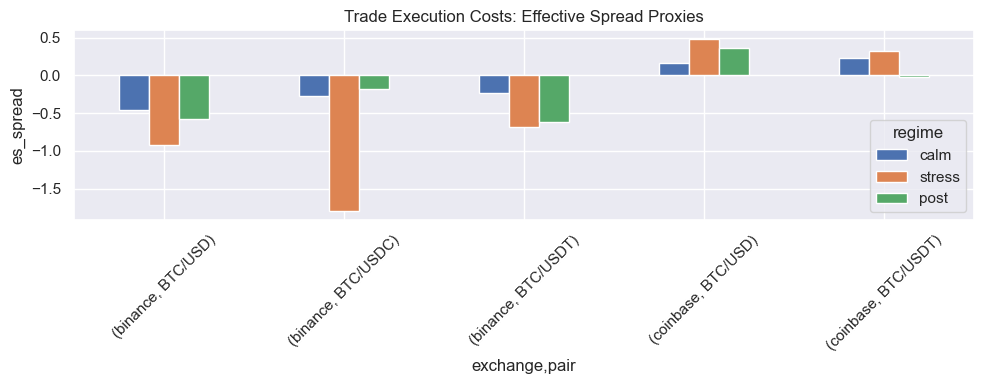

In [31]:
plot_metric(all_summary, "roll_spread", "Liquidity Evaporation: Roll Implied Spreads")
plot_metric(all_summary, "es_spread", "Trade Execution Costs: Effective Spread Proxies")

## GENIUS Act

The empirical findings of this study demonstrate that in the absence of federal regulation, stablecoins acted as vectors for traditional financial contagion. Without regulation, the depegging of USDC severely disrupted digital asset market microstructure. During the March 2023 banking stress, the collapse of SVB caused uncertainty surrounding stablecoin USDC reserve backing triggered a massive flight-to-volume, causing stablecoin volatility to surge to 200% and bid-ask spreads to widen by over 20x compared to calm market conditions (seen in Roll Spread). In stark contrast, native fiat USD order books maintained robust depth and stable execution costs, proving that the liquidity crisis was an artifact of stablecoin credit risk, not fundamental cryptocurrency valuation.

The GENIUS Act is a protection measure, and, more importanly, a critical prerequisite for market efficiency. By mandating strict reserve backing, transparent auditing, and direct oversight by banking regulators, the GENIUS Act effectively would have eliminated the informational asymmetry and default risk that forced market makers to drastically pull liquidity during the 2023 crisis. Under the new regulatory framework, stablecoins are transformed from speculative credit instruments into trusted, structurally sound settlement rails. Consequently, we question whether the GENIUS Act would have successfully eliminated the the systemic microstructure fragmentation observed in this study.  

While the empirical data demonstrates that fiat USD pairs maintain superior liquidity during stress events, it is critical to acknowledge the limitations of the GENIUS Act. If this regulatory framework had been active during the March 2023 crisis, it would not have fully insulated stablecoins from the observed microstructure breakdown.

First, the 2023 USDC depeg was not a failure of crypto-native collateral, but a manifestation of traditional commercial bank counterparty risk. Unless regulatory frameworks grant stablecoin issuers direct access to Federal Reserve Master Accounts, 1:1 reserve requirements merely transfer risk from the blockchain to uninsured deposits at commercial banks, leaving stablecoins vulnerable to fractional-reserve bank runs.

Second, regulation cannot resolve the temporal friction between continuous 24/7 cryptocurrency markets and legacy banking infrastructure. The evaporation of liquidity—evidenced by the 20x spike in the BTC/USDC Roll Spread—was severely exacerbated by the weekend closure of fiat settlement rails (Fedwire), which prevented arbitrageurs from minting and redeeming tokens to enforce the peg. Therefore, while the GENIUS Act improves transparency and baseline solvency, structural market fragmentation and volatility will persist during banking panics until continuous 24/7 fiat settlement infrastructure is fully realized.